# Cursory Statistical Analysis of fare evasion across the network

With the lack-luster results of network-wide evasion. I want to have a curosry look at fare evasion based on pure summary statistics 

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np

In [3]:
Ticket_inspections = pd.read_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe2/Inspections.csv", parse_dates = ["Start_Dtime"])

In [4]:
Ticket_inspections.head()

,Date,Start_Dtime,End_Dtime,Stop_code,Line,Repeat_bus,Visit_number,Unvalidated,Pre_2019
0,2016-02-12,2016-02-12 13:16:51,2016-02-12 13:17:17,7820064-1,1,0.0,1,0,True
1,2016-02-12,2016-02-12 13:33:31,2016-02-12 13:34:12,7820064-1,1,1.0,1,1,True
2,2016-02-12,2016-02-12 13:50:55,2016-02-12 13:51:11,7820064-1,15,0.0,1,1,True
3,2016-02-12,2016-02-12 13:12:26,2016-02-12 13:14:13,7820064-1,20,0.0,1,14,True
4,2016-02-12,2016-02-12 13:19:15,2016-02-12 13:20:15,7820064-1,26,0.0,1,9,True


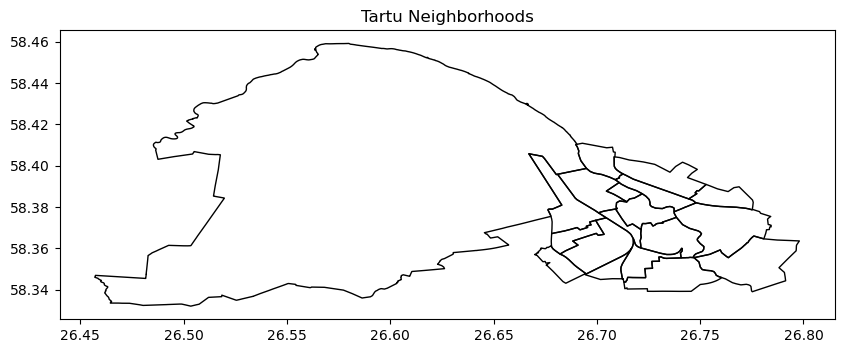

In [6]:
neighborhoods_gdf = gpd.read_file("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/Neighbourhoods/Tartu_linnaosad_wgs84.geojson")
neighborhoods_gdf = neighborhoods_gdf.to_crs("EPSG:3301")

neighborhoods_gdf.plot(edgecolor='black', facecolor='none', figsize=(10,10))
plt.title("Tartu Neighborhoods")
plt.show()

## Mean number of people caught across bus stops with std and support

In [66]:
len(Ticket_inspections)

60798

In [125]:
# Collapsing into day of weekend split only 
Ticket_inspections["Weekend_split"] = Ticket_inspections["Start_Dtime"].dt.weekday.map(lambda x: 0 if x < 5 else 1)

# removing pre_2019 as its applicability to the current route is ambiguous - commented out for now 
#Ticket_inspections = Ticket_inspections[Ticket_inspections["Pre_2019"] == False]

# displaying the score of bus stops as mean number of people caught

Scored = (
    Ticket_inspections
    .groupby("Stop_code")
    .agg(Mean = ("Unvalidated", "mean"),
        std = ("Unvalidated", "std"),
        support = ("Unvalidated", "size"))
    .reset_index()
)

Scored.head()

,Stop_code,Mean,std,support
0,7800528-1,0.000000,NaN,1
1,7800565-1,0.500000,0.707107,2
2,7801229-1,0.000000,NaN,1
3,7820002-1,0.878104,1.490101,443
4,7820003-1,1.236129,1.916806,775


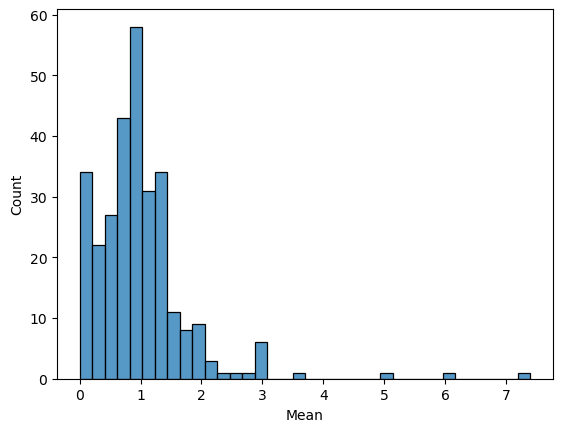

In [126]:
sns.histplot(data = Scored, x = "Mean")
plt.show()

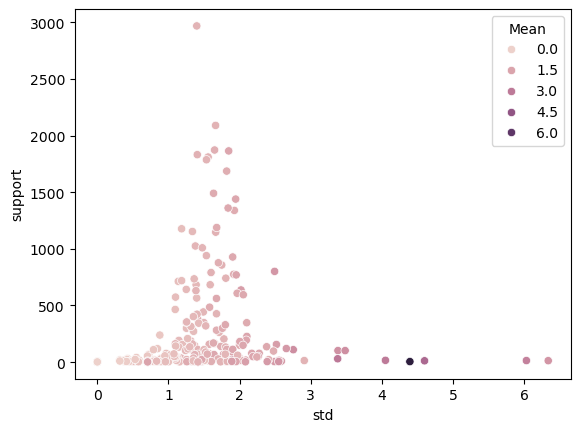

In [127]:
sns.scatterplot(data = Scored, x = "std", y = "support", hue = "Mean")
plt.show()

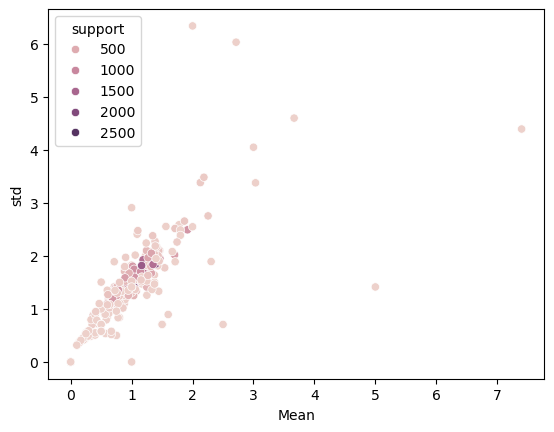

In [128]:
sns.scatterplot(data = Scored, x = "Mean", y = "std", hue = "support")
plt.show()

ideally, as support increase, STD decreases. meaning that we can trust the expected number of people caught. Given that is not the case, it indicates that other variables are at play - most likely pre / post 2019, and temporal 

0.27450980392156865


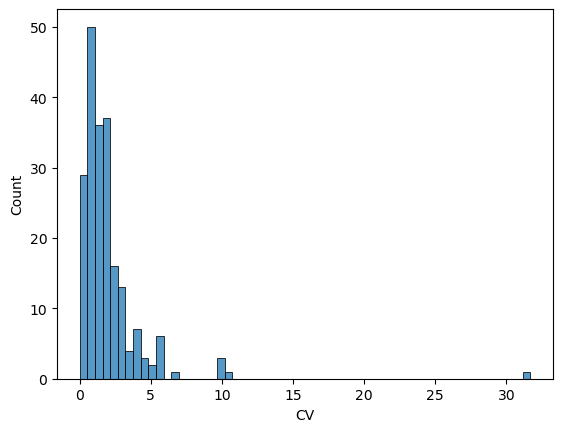

In [141]:
# Co efecint of variation 
# values greater than 1 show that the STD is greater than the MEAN - making for unreliable estimates

Scored["CV"] = Scored["std"] / Scored_temp["Mean"]

# calculating the CV proportion with ZERO taking into account of temporality 
N1 = len(Scored[Scored["CV"] < 1])
N2 = len(Scored[Scored["CV"].notna()])
print(N1 / N2)

sns.histplot(data = Scored, x = "CV")
plt.show()

### pre / post 2019

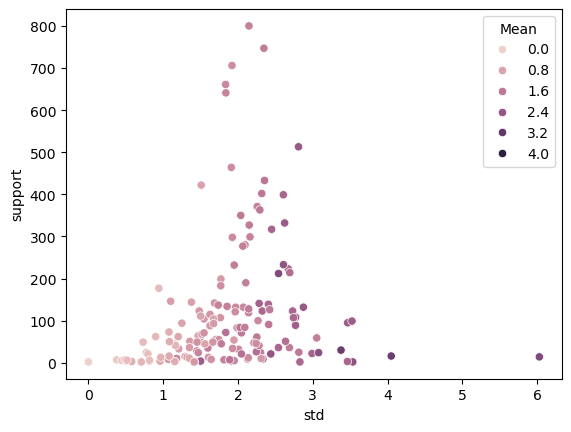

In [80]:
# filtering for post 2019
Ticket_inspections_post = Ticket_inspections[Ticket_inspections["Pre_2019"] == False]

Scored_post = (
    Ticket_inspections_post
    .groupby("Stop_code")
    .agg(Mean = ("Unvalidated", "mean"),
        std = ("Unvalidated", "std"),
        support = ("Unvalidated", "size"))
    .reset_index()
)

sns.scatterplot(data = Scored_post, x = "std", y = "support", hue = "Mean")
plt.show()


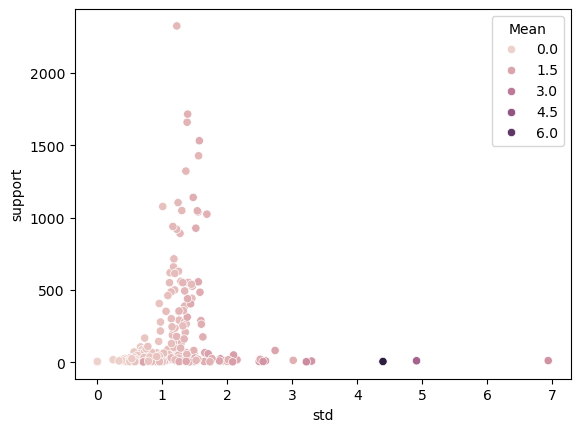

In [81]:
# filtering for pre 2019
Ticket_inspections_pre = Ticket_inspections[Ticket_inspections["Pre_2019"] == True]

Scored_pre = (
    Ticket_inspections_pre
    .groupby("Stop_code")
    .agg(Mean = ("Unvalidated", "mean"),
        std = ("Unvalidated", "std"),
        support = ("Unvalidated", "size"))
    .reset_index()
)

sns.scatterplot(data = Scored_pre, x = "std", y = "support", hue = "Mean")
plt.show()

We can still see that the std is as big as the mean - indicating that predictions are still quite uncertain based purely on summary statistics like this 

## Taking into account temporality 

In [82]:
Ticket_inspections.head()

,Date,Start_Dtime,End_Dtime,Stop_code,Line,Repeat_bus,Visit_number,Unvalidated,Pre_2019,Weekend_split
0,2016-02-12,2016-02-12 13:16:51,2016-02-12 13:17:17,7820064-1,1,0.0,1,0,True,0
1,2016-02-12,2016-02-12 13:33:31,2016-02-12 13:34:12,7820064-1,1,1.0,1,1,True,0
2,2016-02-12,2016-02-12 13:50:55,2016-02-12 13:51:11,7820064-1,15,0.0,1,1,True,0
3,2016-02-12,2016-02-12 13:12:26,2016-02-12 13:14:13,7820064-1,20,0.0,1,14,True,0
4,2016-02-12,2016-02-12 13:19:15,2016-02-12 13:20:15,7820064-1,26,0.0,1,9,True,0


In [93]:
# Binning into time 

Ticket_inspections["Binned_time"] = Ticket_inspections["Start_Dtime"].dt.round("60min")
Ticket_inspections["Binned_time"]  = Ticket_inspections["Binned_time"].dt.time

Scored_temp = Ticket_inspections.groupby(["Stop_code", "Weekend_split", "Binned_time"]).agg(Mean = ("Unvalidated", "mean"),std = ("Unvalidated", "std"),support = ("Unvalidated", "size")).reset_index()

Scored_temp.head()

,Stop_code,Weekend_split,Binned_time,Mean,std,support
0,7800528-1,0,16:00:00,0.0,NaN,1
1,7800565-1,0,13:00:00,0.0,NaN,1
2,7800565-1,0,17:00:00,1.0,NaN,1
3,7801229-1,0,16:00:00,0.0,NaN,1
4,7820002-1,0,07:00:00,1.5,2.12132,2


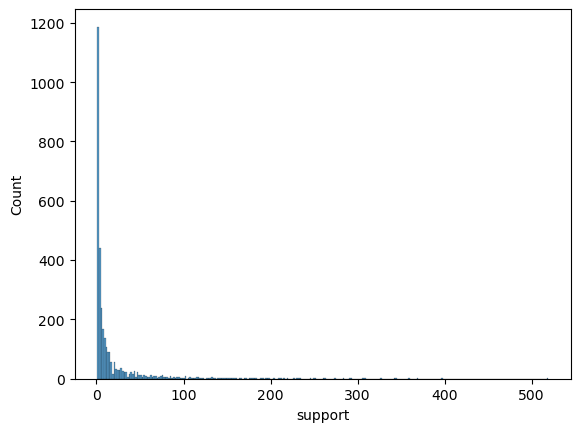

In [94]:
# Here we can see just how badly taking into account temporality - even quite wide bins - results in extreme sparsity for many bus stops
sns.histplot(data = Scored_temp, x = "support")
plt.show()

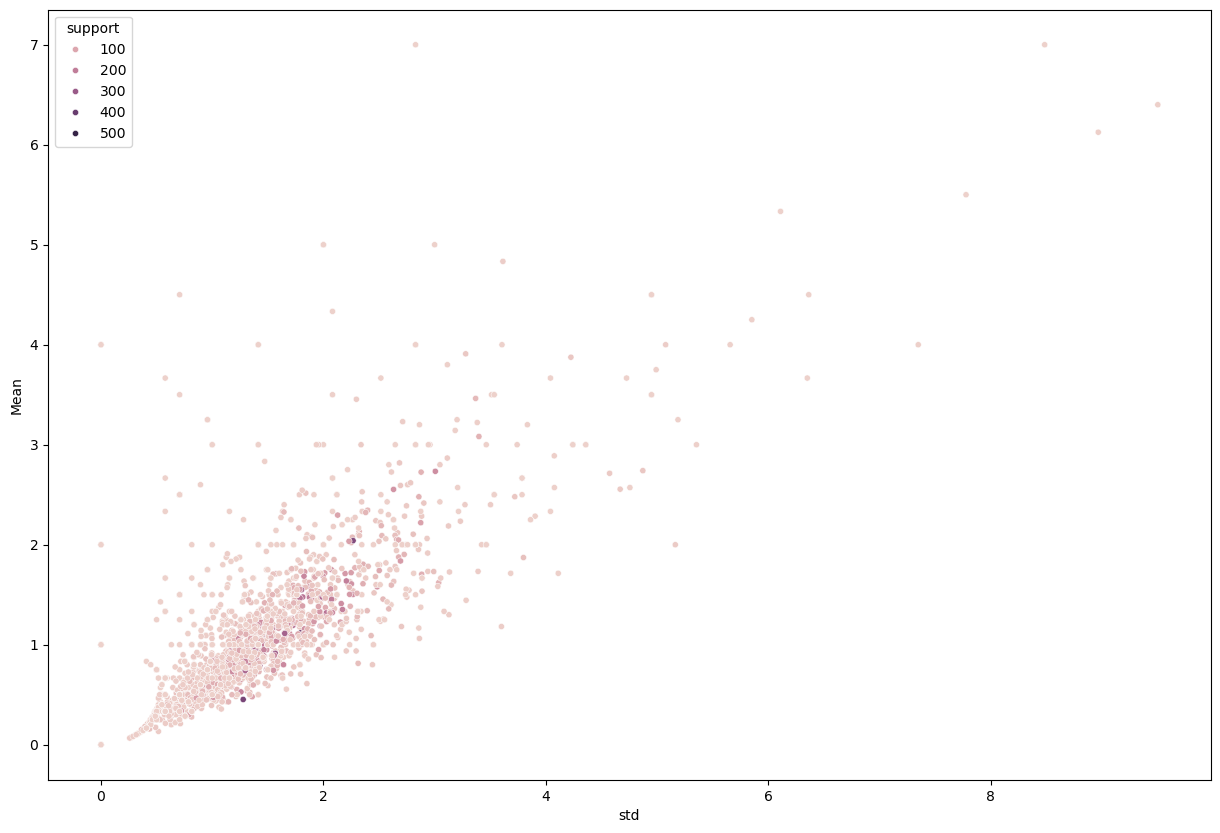

In [112]:
# Here we can see that by taking into account temporality, we now have more windows in which the std is not as large as the mean - indicating that these are more robust 
plt.figure(figsize = (15, 10))
sns.scatterplot(data = Scored_temp, x = "std", y = "Mean", hue = "support", s = 20)
plt.show()

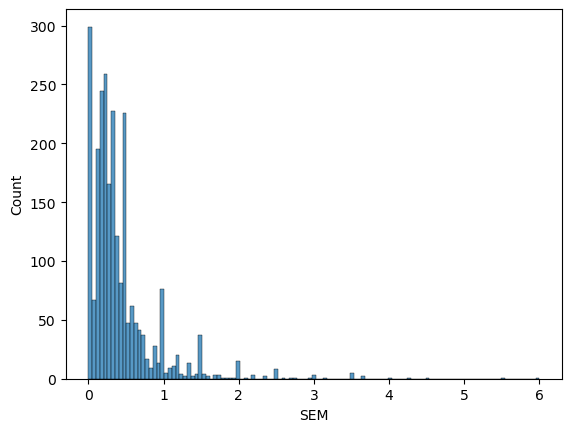

In [117]:
# Now I am going to compute a uncertaintiy score -Standard Error of the Mean (SEM)
# This represent how accurate my estimate of the mean is given the support size

Scored_temp["SEM"] = Scored_temp["std"] / np.sqrt(Scored_temp["support"])

sns.histplot(data = Scored_temp, x = "SEM")
plt.show()

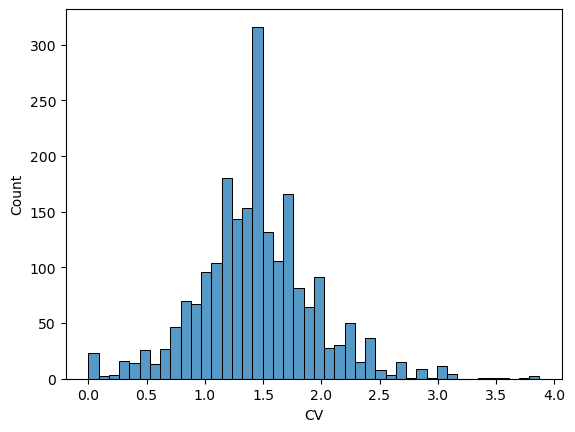

In [143]:
# another unceratity score is the coef3eecint of variation - the data spread given the mean 
# a CV > 1 indicates that the std is GREATER than the mean - indicating noisy data - this is not good and it highlights the noisyness of the data!

Scored_temp["CV"] = Scored_temp["std"] / Scored_temp["Mean"]

# calculating the CV proportion when taking into account of temporality 
N1 = len(Scored_temp[Scored_temp["CV"] < 1])
N2 = len(Scored_temp[Scored_temp["CV"].notna()])
print(N1 / N2)

sns.histplot(data = Scored_temp, x = "CV")
plt.show()

0.2587601078167116


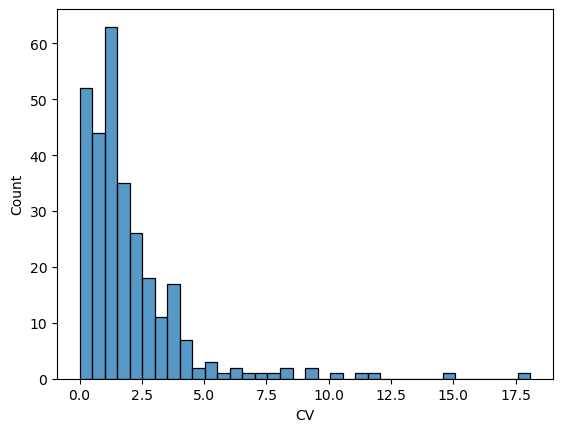

In [145]:

Scored_temp_day_only = Ticket_inspections.groupby(["Stop_code", "Weekend_split"]).agg(Mean = ("Unvalidated", "mean"),std = ("Unvalidated", "std"),support = ("Unvalidated", "size")).reset_index()

Scored_temp_day_only["CV"] = Scored_temp_day_only["std"] / Scored_temp["Mean"]

# calculating the CV proportion when taking into account of temporality 
N1 = len(Scored_temp_day_only[Scored_temp_day_only["CV"] < 1])
N2 = len(Scored_temp_day_only[Scored_temp_day_only["CV"].notna()])
print(N1 / N2)

sns.histplot(data = Scored_temp_day_only, x = "CV")
plt.show()

In [144]:
# When comparing the CV proportion between ZERO temporality  vs Day of Week temporality  vs Day of Week temporality  + Time temporality. 
# we see that including time results in a large dectrease in the number of measurments below. This is somewhat exprected given that the data is getting more sparse.